# Submission1: Membuat Model NLP dengan TensorFlow

- Nama: Hafiizh Taufiqul Hakim
- Email: 2012500720@student.budiluhur.ac.id
- Id Dicoding: hafizhtaufiqul1002

## Download dataset from kaggle

In [1]:
# Install kaggle
!pip install kaggle

In [2]:
# Import file kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hafiizhtaufiqulhakim","key":"b441c5f30c1c72eaf41d95ebbb477fcc"}'}

In [3]:
# Download dataset
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [4]:
!kaggle datasets download -d ishantjuyal/emotions-in-text

  0% 0.00/781k [00:00<?, ?B/s]
100% 781k/781k [00:00<00:00, 23.5MB/s]


In [5]:
# Ekstrak dataset
!mkdir emotions-in-text
!unzip emotions-in-text.zip -d emotions-in-text
!ls emotions-in-text

Archive:  emotions-in-text.zip
  inflating: emotions-in-text/Emotion_final.csv  
Emotion_final.csv


## Load dataset

In [6]:
import pandas as pd

df = pd.read_csv('/content/emotions-in-text/Emotion_final.csv')

In [7]:
df.describe()

,Text,Emotion
count,21459,21459
unique,21405,6
top,i feel so tortured by it,happy
freq,2,7029


In [8]:
df['Emotion'].value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

In [9]:
category = pd.get_dummies(df.Emotion)
df_new = pd.concat([df, category], axis=1)
df_new = df_new.drop(columns='Emotion')
df_new

,Text,anger,fear,happy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0
...,...,...,...,...,...,...,...
21454,Melissa stared at her friend in dism,0,1,0,0,0,0
21455,Successive state elections have seen the gover...,0,1,0,0,0,0
21456,Vincent was irritated but not dismay,0,1,0,0,0,0
21457,Kendall-Hume turned back to face the dismayed ...,0,1,0,0,0,0


## Split data Training dan Validation

In [10]:
text = df_new['Text'].values
label = df_new[['anger', 'fear', 'happy', 'love', 'sadness', 'surprise']].values

In [11]:
from sklearn.model_selection import train_test_split
text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.2, random_state=42)

In [12]:
print("Data Training: ", text_train.shape, label_train.shape)
print("Data test: ", text_test.shape, label_test.shape)

Data Training:  (17167,) (17167, 6)
Data test:  (4292,) (4292, 6)


In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(text_train)
tokenizer.fit_on_texts(text_test)

sequence_train = tokenizer.texts_to_sequences(text_train)
sequence_test = tokenizer.texts_to_sequences(text_test)

padded_train = pad_sequences(sequence_train)
padded_test = pad_sequences(sequence_test)

## Model Sequential

In [14]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax'),
])

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy',
              )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          80000     
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 117702 (459.77 KB)
Trainable params: 117702 (459.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.90):
      print("\nVal_Akurasi telah mencapai > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [16]:
num_epochs = 15
history = model.fit(padded_train,
                    label_train,
                    validation_data=(padded_test, label_test),
                    callbacks=[callbacks],
                    epochs=num_epochs,
                    verbose=2,
                    validation_steps=10
                   )

Epoch 1/15
537/537 - 28s - loss: 1.4030 - accuracy: 0.3752 - val_loss: 1.1061 - val_accuracy: 0.5040 - 28s/epoch - 51ms/step
Epoch 2/15
537/537 - 27s - loss: 0.7815 - accuracy: 0.6880 - val_loss: 0.5880 - val_accuracy: 0.7996 - 27s/epoch - 50ms/step
Epoch 3/15
537/537 - 22s - loss: 0.4067 - accuracy: 0.8645 - val_loss: 0.5150 - val_accuracy: 0.8390 - 22s/epoch - 41ms/step
Epoch 4/15
537/537 - 24s - loss: 0.2607 - accuracy: 0.9138 - val_loss: 0.3701 - val_accuracy: 0.8823 - 24s/epoch - 45ms/step
Epoch 5/15
537/537 - 25s - loss: 0.1912 - accuracy: 0.9340 - val_loss: 0.3208 - val_accuracy: 0.8952 - 25s/epoch - 47ms/step
Epoch 6/15
537/537 - 24s - loss: 0.1458 - accuracy: 0.9491 - val_loss: 0.3382 - val_accuracy: 0.8973 - 24s/epoch - 45ms/step
Epoch 7/15
537/537 - 23s - loss: 0.1155 - accuracy: 0.9573 - val_loss: 0.3743 - val_accuracy: 0.8986 - 23s/epoch - 44ms/step
Epoch 8/15
537/537 - 24s - loss: 0.1018 - accuracy: 0.9638 - val_loss: 0.3405 - val_accuracy: 0.8998 - 24s/epoch - 44ms/step


### plot of accuracy

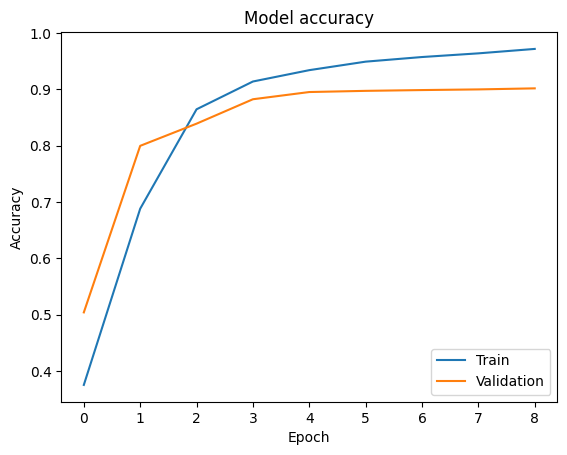

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

### plot of loss

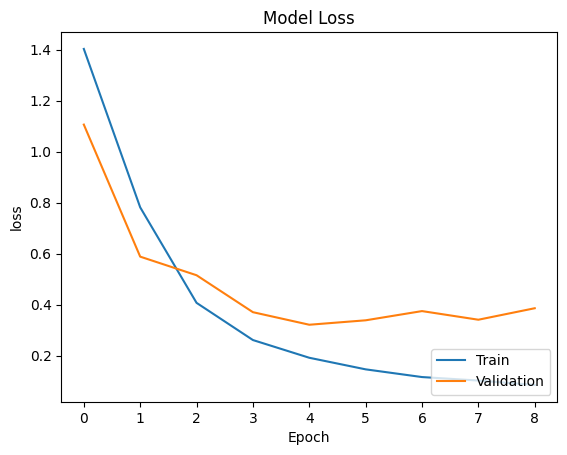

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()